In [24]:
import keras
from keras.datasets import mnist
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

#### Load your data, reserving some for validation. The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

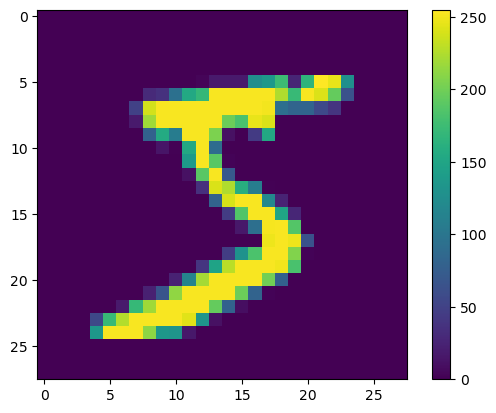

In [26]:
(images, labels), (test_images, test_labels) = mnist.load_data()

plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()


In [27]:
images = images.reshape((60000, 28*28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255

train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

#### Compile the model by specifying its optimizer, the loss function to minimize, and the metrics to monitor

In [28]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

#### Use fit() to train the model, optionally providing validation data to monitor performance on unseen data.

In [29]:
model.fit(
    train_images,
    train_labels,
    epochs=3,
    validation_data=(val_images, val_labels)
)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8653 - loss: 0.4481 - val_accuracy: 0.9571 - val_loss: 0.1455
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9512 - loss: 0.1714 - val_accuracy: 0.9680 - val_loss: 0.1170
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9613 - loss: 0.1327 - val_accuracy: 0.9700 - val_loss: 0.1073


#### Use evaluate() to compute the loss and metrics on new data.

In [30]:
test_metrics = model.evaluate(test_images, test_labels)
test_metrics

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.1241


[0.10455427318811417, 0.9688000082969666]

#### Use predict() to computeclassification probabilities on new data.

In [31]:
predictions = model.predict(test_images)
predictions[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


array([4.0200018e-10, 3.6041079e-12, 3.9076440e-08, 1.2207265e-06,
       1.9072122e-14, 1.3010059e-09, 2.8637991e-16, 9.9999869e-01,
       5.3412071e-12, 9.1768740e-08], dtype=float32)

#### Verify predictions

In [32]:
np.argmax(predictions[0])

np.int64(7)

In [33]:
test_labels[0]

np.uint8(7)

## Writing your own metrics

#### Metrics are key to measuring the performance of your model—in particular, to measuring the difference between its performance on the training data and its performance on the test data.

In [34]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        # Define the state variables in the constructor. Like for layers, you have access to the add_weight() method
        super().__init__(name=name, **kwargs)                                
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")  
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    # Implement the state update logic in update_state(). The y_true argument is the targets (or labels) for one batch, while y_pred represents the
    # corresponding predictions from the model. You can ignore the sample_weight argument—we won’t use it here.
    def update_state(self, y_true, y_pred, sample_weight=None):  
        # To match our MNIST model, we expect categorical predictions and integer labels.
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])   
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [35]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy", RootMeanSquaredError()])

model.fit(train_images, train_labels,
  epochs=3,
  validation_data=(val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8635 - loss: 0.4501 - rmse: 0.4387 - val_accuracy: 0.9575 - val_loss: 0.1459 - val_rmse: 0.2536
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9506 - loss: 0.1691 - rmse: 0.2747 - val_accuracy: 0.9683 - val_loss: 0.1124 - val_rmse: 0.2215
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9628 - loss: 0.1318 - rmse: 0.2406 - val_accuracy: 0.9710 - val_loss: 0.1105 - val_rmse: 0.2129
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9685 - loss: 0.1230 - rmse: 0.2206


## Using callbacks
#### A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to fit() and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.

<ul>
    <li>Model checkpointing—Saving the current state of the model at different points during training.</li>
    <li>Early stopping—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training)</li>
    <li>Dynamically adjusting the value of certain parameters during training—Such as the learning rate of the optimizer.</li>
    <li>Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated</li>
</ul>

#### The keras.callbacks module includes a number of built-in callbacks:
<ul>
    <li>keras.callbacks.ModelCheckpoint</li>
    <li>keras.callbacks.EarlyStopping</li>
    <li>keras.callbacks.LearningRateScheduler</li>
    <li>keras.callbacks.ReduceLROnPlateau</li>
    <li>keras.callbacks.CSVLogger</li>
</ul>

#### THE EARLYSTOPPING AND MODELCHECKPOINT CALLBACKS
##### The EarlyStopping callback interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs. This callback is typically used in combination with ModelCheckpoint, which lets you continually save the model during training. 


In [36]:
# Callbacks are passed to the model via the callbacks argument in fit(), which takes a list of callbacks. You can pass any number of callbacks

callbacks_list = [     
    keras.callbacks.EarlyStopping(    # Interrupts training when improvement stops
        monitor="val_accuracy",       # Monitors the model’s validation accuracy         
        patience=2,                   # Interrupts training when accuracy has stopped improving for 2 epochs
    ),
    keras.callbacks.ModelCheckpoint(    # Saves the current weights after every epoch
        filepath="checkpoint_path.keras",    
        # These two arguments mean you won’t overwrite the model file unless val_loss has improved, 
        # which allows you to keep the best model seen during training.
        monitor="val_loss",                
        save_best_only=True,              
    )
]

model = get_mnist_model()

model.compile(optimizer="rmsprop",
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"])

model.fit(
    train_images, 
    train_labels,                
    epochs=10,                                 
    callbacks=callbacks_list,                  
    validation_data=(val_images, val_labels)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8644 - loss: 0.4492 - val_accuracy: 0.9571 - val_loss: 0.1495
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9520 - loss: 0.1652 - val_accuracy: 0.9684 - val_loss: 0.1154
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9623 - loss: 0.1255 - val_accuracy: 0.9736 - val_loss: 0.1015
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9698 - loss: 0.1104 - val_accuracy: 0.9756 - val_loss: 0.0961
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9710 - loss: 0.1001 - val_accuracy: 0.9773 - val_loss: 0.0918
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9734 - loss: 0.0921 - val_accuracy: 0.9765 - val_loss: 0.0970
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9765 - loss: 0.0848 - val_accuracy: 0.9777 - val_loss: 0.0937
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9788 - loss: 0.0803 - 

#### you can always save models manually after training as well—just call model.save('my_checkpoint_path').
#### To reload the model you’ve saved, just use
#### model = keras.models.load_model("checkpoint_path.keras")

## Writing your own callbacks
<ul>
    <li>on_epoch_begin(epoch, logs): Called at the START of every EPOCH</li>
    <li>on_epoch_end(epoch, logs) : Called at the END of every EPOCH</li>
    <li>on_batch_begin(batch, logs) :  Called right BEFORE processing EACH BATCH</li>
    <li>on_batch_end(batch, logs) : Called right AFTER processing EACH BATCH</li>
    <li>on_train_begin(logs) :  Called at the START of TRAINING</li>
    <li>on_train_end(logs) : Called at the END of TRAINING</li>
</ul>

In [37]:
from matplotlib import pyplot as plt
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
         self.per_batch_losses = []
 
    def on_batch_end(self, batch, logs):
         self.per_batch_losses.append(logs.get("loss"))
 
    def on_epoch_end(self, epoch, logs):
         plt.clf()
         plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
             label="Training loss for each batch")
         plt.xlabel(f"Batch (epoch {epoch})")
         plt.ylabel("Loss")
         plt.legend()
         plt.savefig(f"plot_at_epoch_{epoch}")
         self.per_batch_losses = []

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8673 - loss: 0.4367 - val_accuracy: 0.9552 - val_loss: 0.1552
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9502 - loss: 0.1697 - val_accuracy: 0.9679 - val_loss: 0.1159
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9620 - loss: 0.1295 - val_accuracy: 0.9725 - val_loss: 0.1049
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9674 - loss: 0.1155 - val_accuracy: 0.9745 - val_loss: 0.0972
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9717 - loss: 0.1033 - val_accuracy: 0.9772 - val_loss: 0.0926
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9723 - loss: 0.0968 - val_accuracy: 0.9758 - val_loss: 0.1047
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9770 - loss: 0.0859 - val_accuracy: 0.9774 - val_loss: 0.1011
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9774 - loss: 0.0831 - 

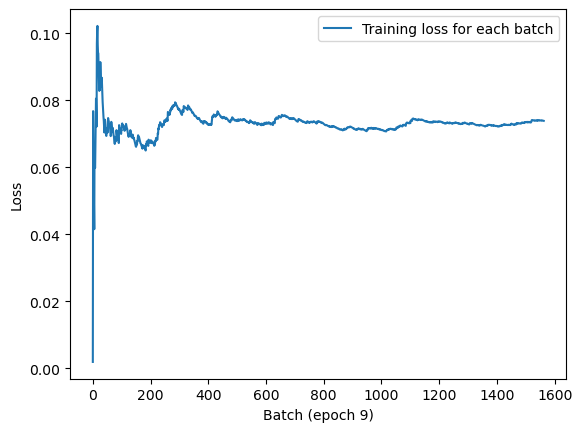

In [38]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"])

model.fit(train_images, train_labels,
  epochs=10,
  callbacks=[LossHistory()],
  validation_data=(val_images, val_labels))